# Deep Learning Portfolio 1

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [LSTM voor audioclip](#Model1)
    - [LSTM voor songtekste](#Model2)
    - [Transformer voor songtekste](#Model3)
    - [Model naar keuze](#Model4)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)
- [Submission functie](#Submission-functie)
- [HTML functie](#HTML-functie)

In [4]:
# !pip install keras-tuner --upgrade
# !pip install wordcloud


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import PIL
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from PIL import Image
from sklearn.preprocessing import StandardScaler
from keras_tuner import HyperParameters  as hp
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models

## Data Overview

In [5]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data importeren

In [12]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 2 Datasets/test.csv')

## Exploratory Data Analysis

In [13]:
df_train.head()

,filename,lyrics,genre
0,blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues
1,blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues
2,blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues
3,blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
4,blues.00006.wav,My baby left me this morning\nPeople just arou...,blues


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  537 non-null    object
 1   lyrics    537 non-null    object
 2   genre     537 non-null    object
dtypes: object(3)
memory usage: 12.7+ KB


In [16]:
df_train.describe()

,filename,lyrics,genre
count,537,537,537
unique,537,500,8
top,rock.00099.wav,"[Intro: Lil' Kim, Mýa, Christina Aguilera & P!...",rock
freq,1,4,79


###Missende waarde:

In [17]:
df_train.isnull().sum()

,0
filename,0
lyrics,0
genre,0


###Kolommen beschrijving:

filename is uniek voor elk nummer.

lyrics bevat songteksten, sommige teksten lijken intro’s, stukken tekst of gesproken tekst te bevatten.

genre bevat 8 unieke genres.
Het meest voorkomende genre is rock (79 keer).

###Verdeling van genres

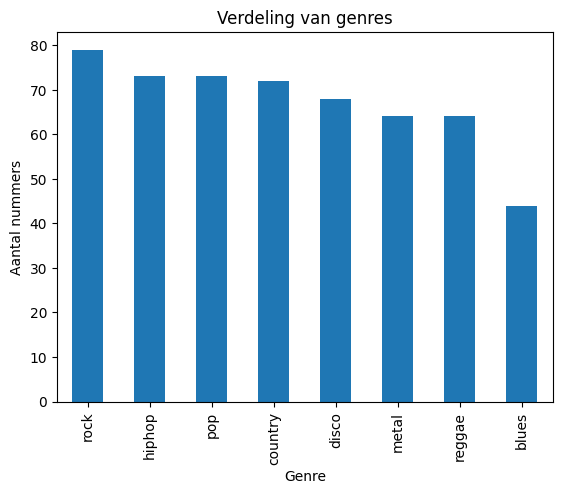

In [21]:

# 1. Verdeling van genres
genre_counts = df_train['genre'].value_counts()

genre_counts.plot(kind='bar')
plt.title('Verdeling van genres')
plt.xlabel('Genre')
plt.ylabel('Aantal nummers')
plt.show()

###Verdeling van lyrics lengte

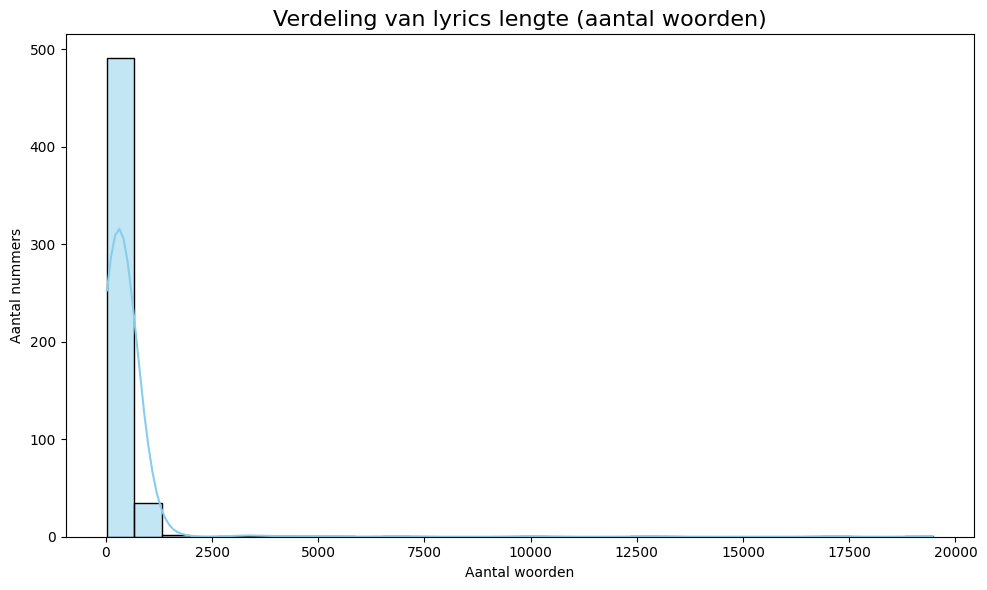

In [22]:
# 2. Lengte van lyrics
df_train['lyrics_length'] = df_train['lyrics'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(df_train['lyrics_length'], kde=True, bins=30, color='skyblue')
plt.title('Verdeling van lyrics lengte (aantal woorden)', fontsize=16)
plt.xlabel('Aantal woorden')
plt.ylabel('Aantal nummers')
plt.tight_layout()
plt.show()


###Woordwolken per genre

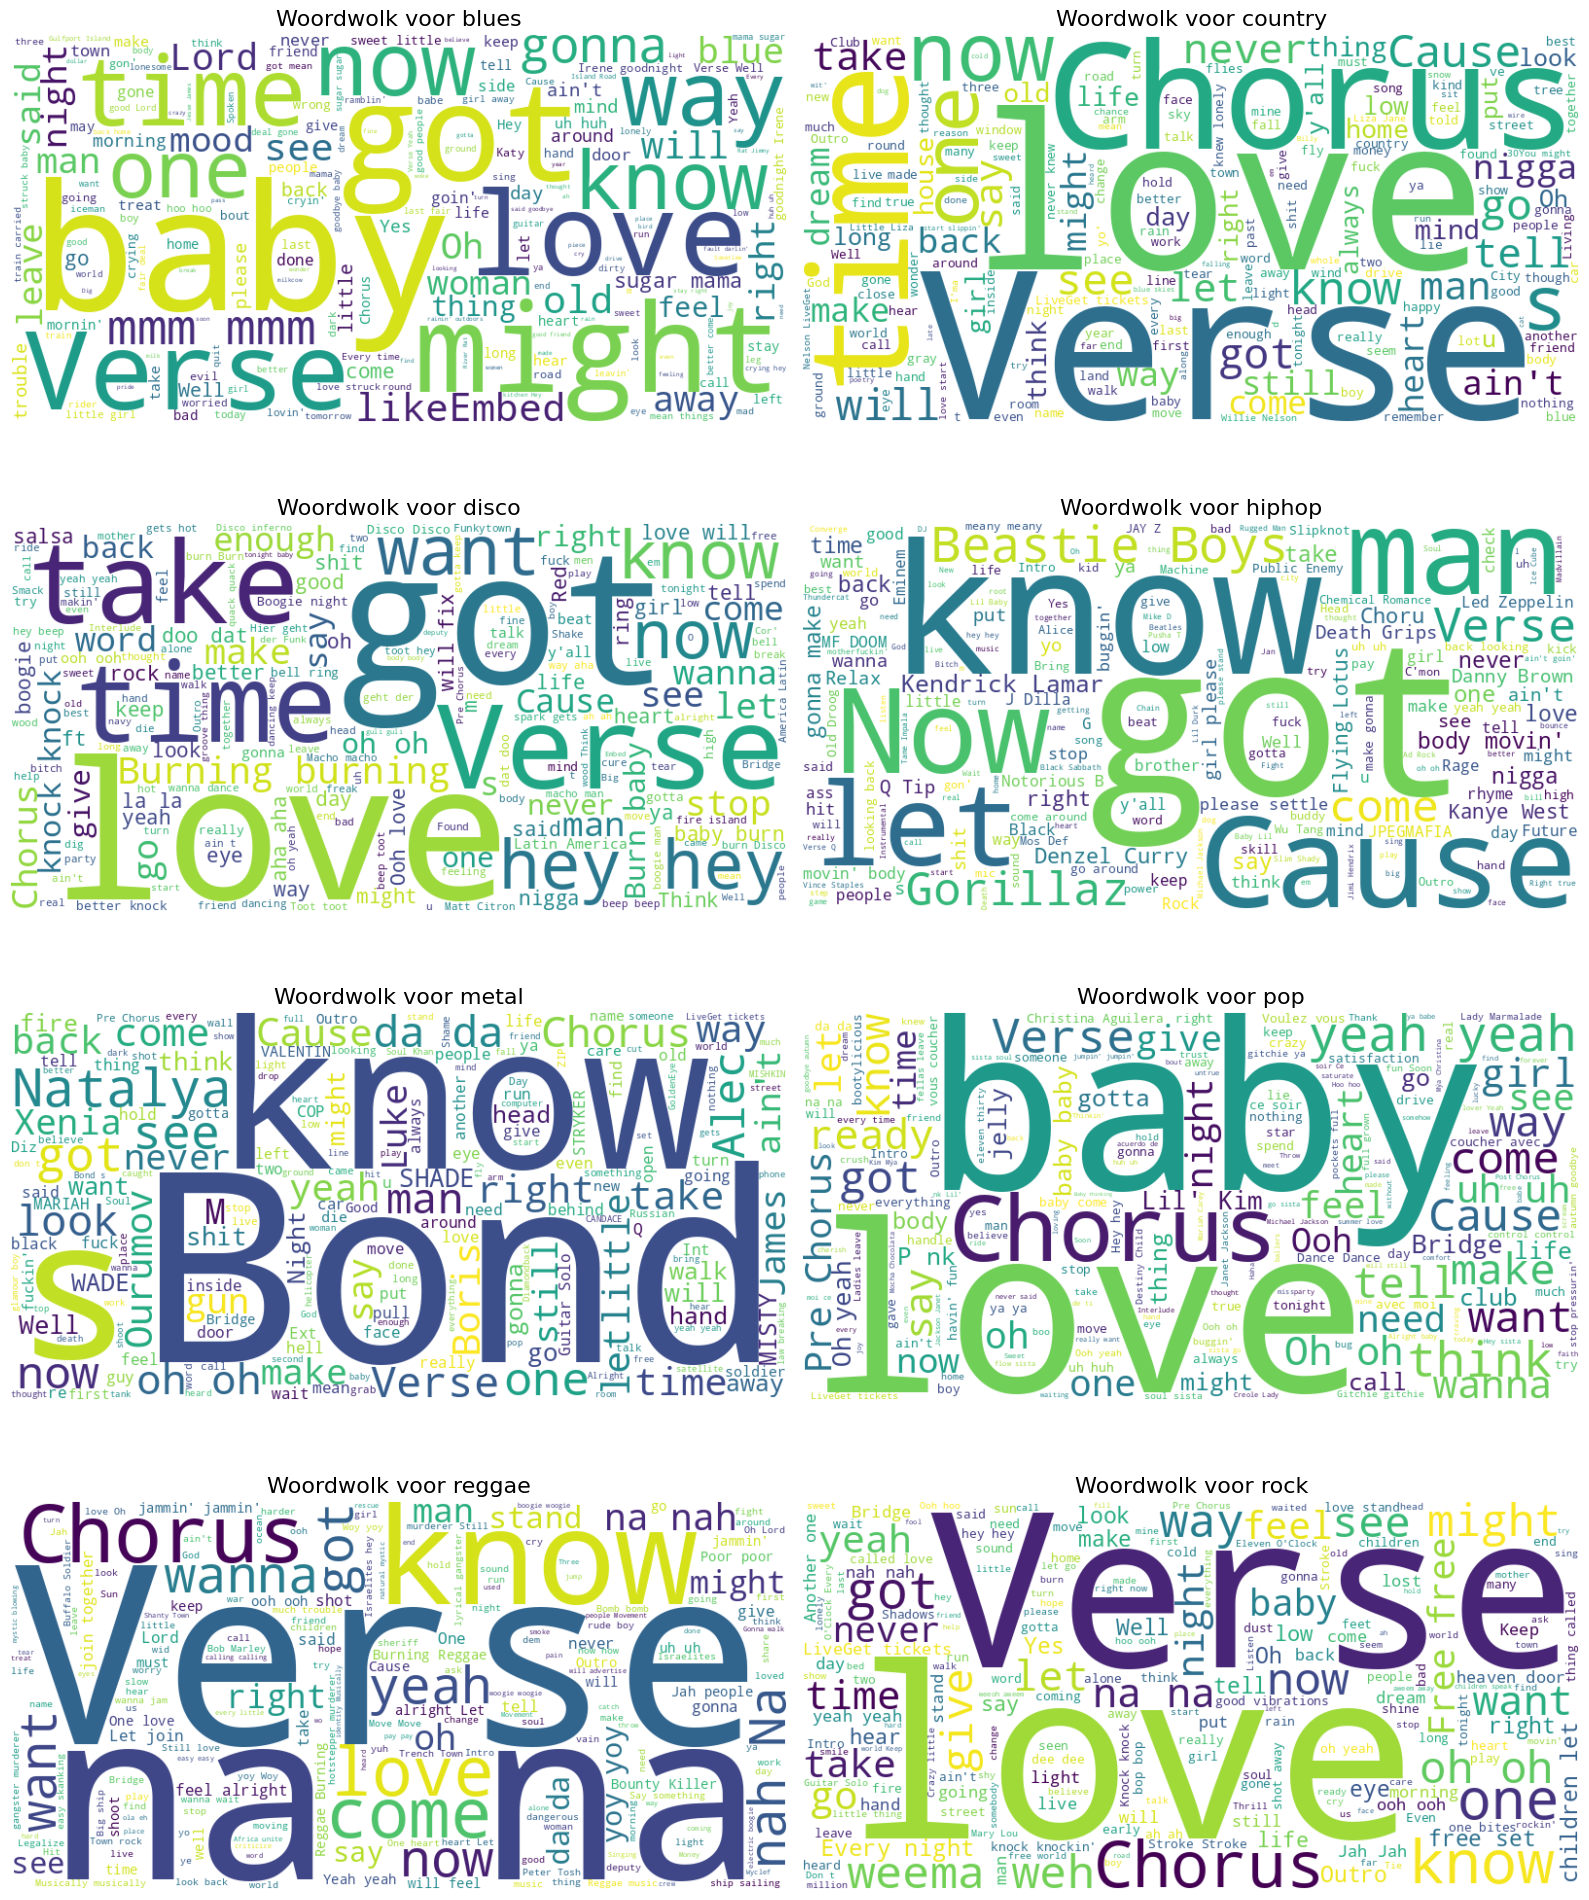

In [27]:
# 3. Woordwolken per genre
genres = df_train['genre'].unique()
fig, axs = plt.subplots(len(genres)//2, 2, figsize=(16, 20))
axs = axs.flatten()

for i, genre in enumerate(genres):
    text = " ".join(df_train[df_train['genre'] == genre]['lyrics'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text) # Now WordCloud is defined
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'Woordwolk voor {genre}', fontsize=16)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

<ipython-input-29-8ef50bb31615>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='genre', y='lyrics_length', palette='Set3')


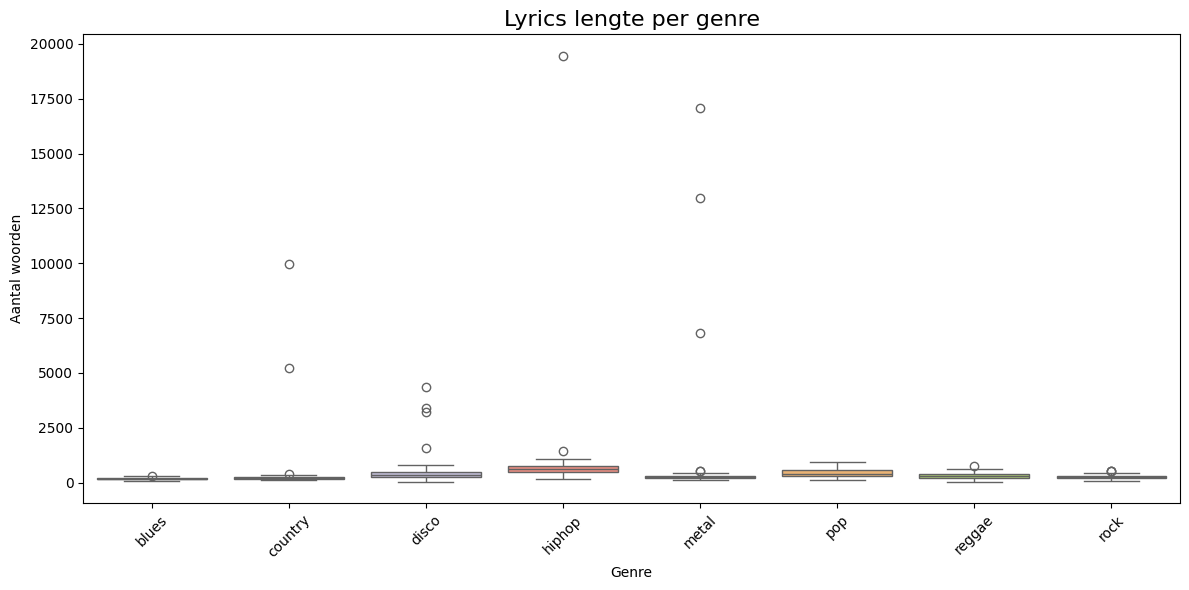

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Lyrics lengte per genre (boxplot)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train, x='genre', y='lyrics_length', palette='Set3')
plt.title('Lyrics lengte per genre', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Aantal woorden')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


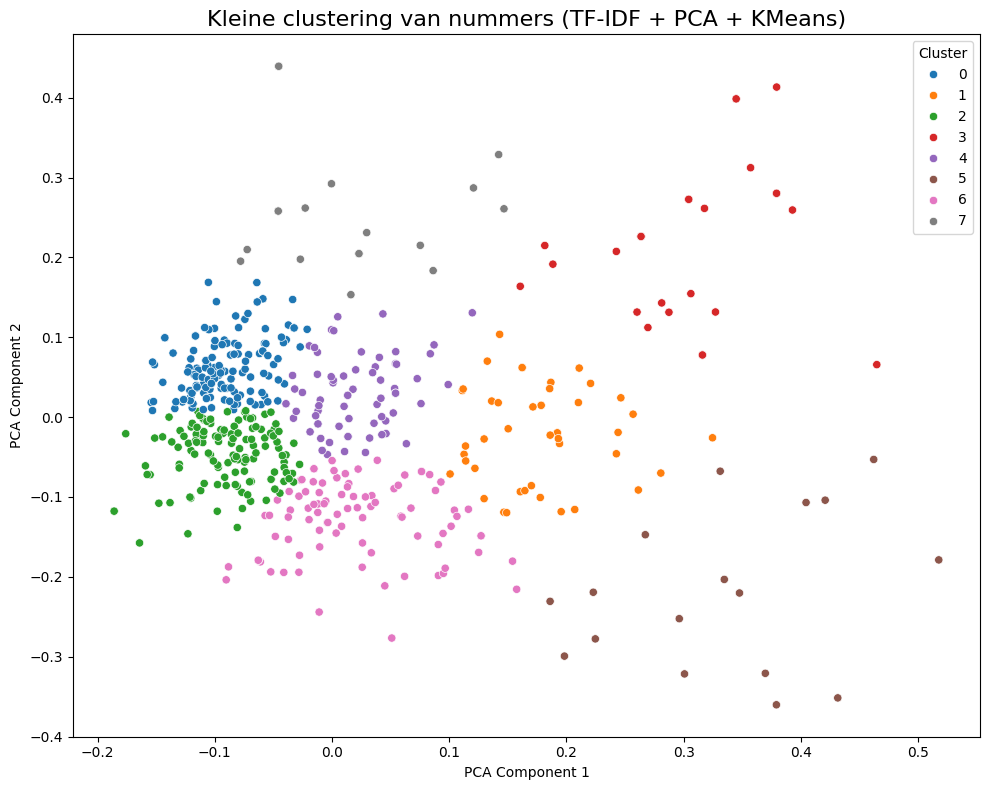

In [30]:
# 2. Top 10 woorden per genre
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

top_words_per_genre = {}

for genre in genres:
    lyrics = " ".join(df_train[df_train['genre'] == genre]['lyrics']).lower()
    words = re.findall(r'\b\w+\b', lyrics)
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    most_common = Counter(filtered_words).most_common(10)
    top_words_per_genre[genre] = most_common

# Resultaten tonen
top_words_per_genre

# 3. Simpele clustering met TF-IDF + PCA
# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(df_train['lyrics'])

# PCA voor 2D visualisatie
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Plot
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='tab10', legend='full')
plt.title('Kleine clustering van nummers (TF-IDF + PCA + KMeans)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [32]:
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download stopwoorden (alleen de eerste keer nodig)
nltk.download('stopwords')


# Engelse stopwoorden ophalen
stop_words = set(stopwords.words('english'))

# Top 10 woorden per genre bepalen
top_words_per_genre = {}

genres = df_train['genre'].unique()

for genre in genres:
    # Alle lyrics van dit genre combineren
    lyrics = " ".join(df_train[df_train['genre'] == genre]['lyrics']).lower()

    # Woorden extraheren
    words = re.findall(r'\b\w+\b', lyrics)

    # Stopwoorden en korte woorden (<3 letters) verwijderen
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

    # Meest voorkomende woorden tellen
    most_common = Counter(filtered_words).most_common(10)

    # Opslaan
    top_words_per_genre[genre] = most_common

# Resultaat tonen
for genre, words in top_words_per_genre.items():
    print(f"\nTop 10 woorden voor genre '{genre}':")
    for word, count in words:
        print(f"{word}: {count} keer")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top 10 woorden voor genre 'blues':
baby: 109 keer
got: 61 keer
verse: 57 keer
might: 53 keer
love: 52 keer
also: 44 keer
little: 40 keer
time: 39 keer
like: 37 keer
mama: 32 keer

Top 10 woorden voor genre 'country':
like: 204 keer
love: 145 keer
chorus: 124 keer
verse: 123 keer
never: 98 keer
see: 89 keer
one: 87 keer
let: 84 keer
time: 81 keer
might: 80 keer

Top 10 woorden voor genre 'disco':
love: 283 keer
get: 259 keer
like: 256 keer
got: 170 keer
hey: 168 keer
boogie: 149 keer
baby: 144 keer
burning: 142 keer
yeah: 139 keer
man: 135 keer

Top 10 woorden voor genre 'hiphop':
like: 415 keer
get: 362 keer
got: 300 keer
verse: 231 keer
make: 217 keer
yeah: 212 keer
body: 210 keer
man: 207 keer
know: 204 keer
gonna: 191 keer

Top 10 woorden voor genre 'metal':
bond: 470 keer
like: 320 keer
know: 220 keer
natalya: 201 keer
yeah: 178 keer
got: 173 keer
see: 163 keer
chorus: 161 keer
one: 150 keer
man: 149 keer

Top 10 woorden voor genre 'pop':
yeah: 430 keer
baby: 421 keer
chorus: 307 

## Feature Engineering

## Modeling

# LSTM voor audioclip

#### Hypertuning

#### Modelarchitectuur

In [ ]:
plot_model(model name, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# LSTM voor songtekste

#### Hypertuning

#### Modelarchitectuur

In [ ]:
plot_model(model name, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# Transformer voor songtekste

#### Hypertuning

#### Modelarchitectuur

In [ ]:
plot_model(model name, show_shapes=True, rankdir="LR")

#### Plot

#### Beste parameters  

# Model naar keuze

### Model code

#### Modelarchitectuur

In [ ]:
plot_model(model name, show_shapes=True, rankdir="LR")

#### Plot

### Hypertuning

#### Beste parameters



## Results

### Overview

### Scores

## Conclusion & Advice

|Model|Notebook|Kaggle|
|----|------|------|
||||
||||
||||
||||

### Submission functie

In [ ]:
import numpy as np
import pandas as pd

def submission(pred, test_df, filename):
    """
    Creates a submission file for a prediction.

    Args:
        pred (np.ndarray): The predictions.
        test_df (pd.DataFrame): The test dataframe.
        filename (str): The filename of the submission file (must include .csv extension).

    Returns:
        pd.DataFrame: The submission dataframe.
    """
    # Ensure pred is a 1D array and has the same length as test_df
    pred = pred.reshape(-1)  # Flatten if necessary
    pred = pred[:len(test_df)]  # Truncate to match test_df length

    # Create the submission DataFrame
    df = pd.DataFrame({'House ID': test_df['House ID'], 'Price': pred})

    # Save the DataFrame to a CSV file
    df_n = df.to_csv(filename, index=False)

    # Return the DataFrame (optional)
    return df_n

## Sources

### Html

In [ ]:
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Portfolio_1.ipynb to Portfolio_1.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>